In [2]:
import dgl
import dgl.nn as gnn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import networkx as nx

Using backend: pytorch


# Stochastic Training

В ситуации, когда имеется большой граф, очень легко выйти за пределы имеющейся памяти. Потенциальное решение: обучение на основе минибатчей.

## Frontier, MFG, block

Для каждого шага градиентного спуска выбирается минибатч из узлов, финальные скрытые представления которых после `L` слоя сети должны быть рассчитаны. После этого на `L-1` слое рассматриваются все (или некоторые) их соседи. Эта процедура повторяется, пока мы не достигнем первого слоя сети.

Такая процедура позволяет построить граф зависимостей, необходимый для расчетов (иногда это называют графом вычислений; в `DGL` используется термин message flow graphs (MFGs))

![](./assets/img/10_dgl_stochastic_deps.png)


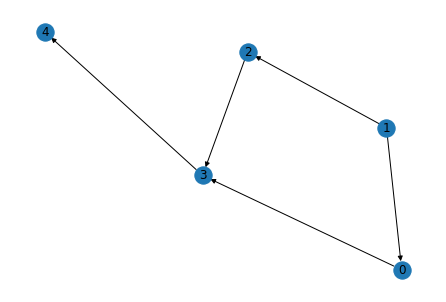

In [3]:
src = torch.tensor([0,1,1,2,3 ])
dst = torch.tensor([3,0,2,3,4 ])
G = dgl.graph((src, dst))
G.ndata['feat'] = torch.randn((G.num_nodes(), 5))
nx.draw(dgl.to_networkx(G), with_labels=True)

Допустим, мы планируем создать сеть с `L=2` слоями и нас интересует представление только узла `4`.

Для расчета представления узла `4` на `l=2` слое, нужно получить представления узла `3`: $m_4^{2} = M(\{h_3^{1}\})$

Frontier (фронт (как в BFS?)) второго слоя сети - это граф, который содержит все узлы оригинального графа, но только те ребра, которые необходимы для передаче сообщений выходным узлам (в этом примере - узлу 4). 

Для получения фронта можно воспользоваться функцией `dgl.in_subgraph`, которая порождает подграф, содержащий все узлы исходного графа, и только те ребра, которые входят в узлы из заданного множества. 

In [25]:
frontier = dgl.in_subgraph(G, [4])
print(frontier.all_edges())
print(frontier.num_nodes())

(tensor([3]), tensor([4]))
5


Проблема в том, что выполнять рассылку сообщений на этом графе нельзя, т.к. он содержит все узлы из исходного графа, а нам нужны только узлы 3 и 4 (как вход слоя) и узел 4 (как выход слоя).

Авторы `DGL` конструируют на основе этих узлов двудольный граф, где узлы делятся на 2 типа: входные и выходные (их кол-во отличается). Такой двудольный граф авторы называются message flow graph.

Множество выходных узлов всегда является подмножеством входных узлов, т.к. для расчета представления выходных узлов следующего слоя требуются их представления с предыдущего слоя.

Технически любой подграф, содержащий все узлы, может называться фронтом, но при создании MFG `DGL` проверяет, что множество целевых узлов покрывает множество конечных узлов имеющихся в подграфе ребер.

Для превращения фронта в MFG `DGL` предоставляет функцию `dgl.to_block`.

У MFG (block) есть несколько специфичных атрибутов:
* `.srcnodes` для обращения к входным узлам (аналогично `.nodes` у обычных графов)
* `.srcdata` для обращения к фичам входных узлов (аналогично `.ndata` у обычных графов)
* `.dstnodes` для обращения к выходным узлам
* `.dstdata` для обращения к фичам выходных узлов

In [24]:
dst_nodes = torch.LongTensor([4])
block = dgl.to_block(frontier, dst_nodes)
print(f'{block.number_of_src_nodes()=}')
print(f'{block.number_of_dst_nodes()=}')
print(f'{block.srcdata[dgl.NID]=}') # выходные узлы всегда будут находиться в начале
print(f'{block.dstdata[dgl.NID]=}')

block.number_of_src_nodes()=2
block.number_of_dst_nodes()=1
block.srcdata[dgl.NID]=tensor([4, 3])
block.dstdata[dgl.NID]=tensor([4])


## Neighborhood sampling

Построение MFG - настраиваемый процесс, в который можно вносить модификации. Например, в целях ускорения обучения иногда удобно рассматривать не всех соседей, а некоторое их подножество. `DGL` предоставляет инструменты для манипулирования процессом сэмплинга соседей.

В `DGL` есть несколько классов (сэмплеров), которые генерируют граф зависимостей для каждого из слоев в зависимости от узлов, для которых мы хотим провести расчеты.

Простейший вариант - `MultiLayerFullNeighborSampler`, который подразумевает, что узел получает сообщения от всех своих соседей.

In [5]:
src = torch.randint(0, 100, (500, ))
dst = torch.randint(0, 100, (500, ))

train_ids = torch.randint(0, 100, (30,))

G = dgl.graph((src, dst))
G

Graph(num_nodes=100, num_edges=500,
      ndata_schemes={}
      edata_schemes={})

Допустим, у нас есть набор узлов `train_ids` для обучения. Нам нужно разбить его на батчи и создать для каждого батча MFG.

Для этого мы сначала создаем нужный сэмплер. Затем на его основе создаем dataloader. Итерируясь по этому dataloader'у, мы получаем набор специальным образом сгенерированных графов, отражающих зависимости на каждом из слоев.

In [6]:
sampler = dgl.dataloading.MultiLayerFullNeighborSampler(n_layers=2)
dataloader = dgl.dataloading.NodeDataLoader(G, train_ids, sampler,
                                            batch_size=5, shuffle=True,
                                            drop_last=False, num_workers=4)

input_nodes, output_nodes, blocks = next(iter(dataloader))                                          

[Block(num_src_nodes=81, num_dst_nodes=32, num_edges=155), Block(num_src_nodes=32, num_dst_nodes=5, num_edges=34)]


In [10]:
# input_nodes - набор узлов, необходимый для вычисления представлений узлов 
# из output_nodes
print(input_nodes)
print('требуются для вычислений по узлам:')
print(output_nodes)

tensor([84, 80, 29, 54, 37, 68, 43, 66, 99, 72,  4, 20, 25, 70, 90, 61, 27, 28,
        49, 26, 15, 65, 46, 95, 35, 71, 75, 64, 48, 78, 69, 13, 83, 32, 59, 89,
         1, 11,  3, 44, 39, 45, 21, 19, 77, 51, 33,  5, 67, 10, 52, 56, 58, 23,
        22,  7, 16, 55, 40, 12, 91, 81, 36, 86, 31, 85, 82, 93, 63, 87, 79, 14,
         0, 47, 97, 60, 73,  2, 57,  9, 18])
требуются для вычислений по узлам:
tensor([84, 80, 29, 54, 37])


In [12]:
# blocks содержат для каждого слоя описания того, представления каких узлов
# будут рассчитаны на выходе, представления каких узлов нужны на входе
# и как представления от входов распространяются к выходу
blocks

[Block(num_src_nodes=81, num_dst_nodes=32, num_edges=155),
 Block(num_src_nodes=32, num_dst_nodes=5, num_edges=34)]

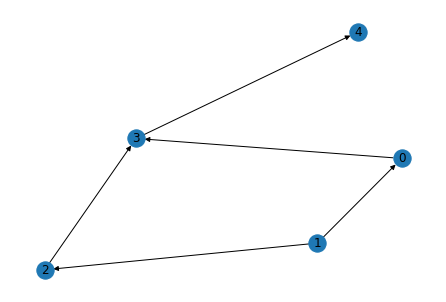

In [27]:
# простой пример графа
src = torch.tensor([0,1,1,2,3 ])
dst = torch.tensor([3,0,2,3,4 ])
G = dgl.graph((src, dst))
G.ndata['feat'] = torch.randn((G.num_nodes(), 5))
nx.draw(dgl.to_networkx(G), with_labels=True)

In [28]:
sampler = dgl.dataloading.MultiLayerFullNeighborSampler(n_layers=2)
dataloader = dgl.dataloading.NodeDataLoader(G, [4], sampler,
                                            batch_size=1)

input_nodes, output_nodes, blocks = next(iter(dataloader))      
print(f'{input_nodes=}')                                    
print(f'{output_nodes=}')                                    
print(f'{blocks=}')                                    

input_nodes=tensor([4, 3, 0, 2])
output_nodes=tensor([4])
blocks=[Block(num_src_nodes=4, num_dst_nodes=2, num_edges=3), Block(num_src_nodes=2, num_dst_nodes=1, num_edges=1)]


In [29]:
layer1 = gnn.SAGEConv(5, 3, aggregator_type='mean')
layer2 = gnn.SAGEConv(3, 2, aggregator_type='mean')
features = G.ndata['feat'][input_nodes]
print(features)
# если взять 4 узла из block[0] и выполнить рассылку сообщений, то получим
# представления 2 узлов
out = layer1(blocks[0], features)
print(out)
# если взять 2 узла из block[1] и выполнить рассылку сообщений, то получим
# представления 1 узла
out = layer2(blocks[1], out)
print(out)

tensor([[-1.3466,  0.0613,  1.2991,  0.9760, -1.2939],
        [-1.3669, -0.5564,  1.5476,  0.3555,  0.6966],
        [ 1.6469,  0.5162,  1.1806, -0.8277, -0.1649],
        [ 0.3318,  1.2898,  0.5696, -0.2475, -0.5783]])
tensor([[ 7.7012,  3.6908, -0.5703],
        [ 0.0434,  2.5330,  3.9764]], grad_fn=<AddBackward0>)
tensor([[ -2.0477, -22.9975]], grad_fn=<AddBackward0>)


`DGL` предоставляет возможности для реализации своей стратегии сэмплирования соседей.

Базовый класс сэмплеров - `BlockSampler` - отвечает за генерацию списка MFGs, начиная с последнего слоя, при помощи метода `sample_blocks()`. Базовая реализация этого метода - идти от последнего слоя к первому, генерировать фронты и преобразовывать их в MFGs.

Если требуется реализовать кастомное поведение, достаточно определить метод `sample_blocks()`. Он должен принимать на вход: 
1. Слой, для которого генерируется фронт
2. Исходный граф
3. Узлы, для которых на этом слое рассчитываются представления (`output_nodes` или `seed_nodes`).

In [30]:
# пример реализации простейшего сэмплера
class MultiLayerFullNeighborSampler(dgl.dataloading.BlockSampler):
    def __init__(self, n_layers):
        super().__init__(n_layers)

    def sample_frontier(self, block_id, g, seed_nodes):
        frontier = dgl.in_subgraph(g, seed_nodes)
        return frontier

Пример более сложного сэмплера, который позволяет сэмплировать небольшое количество соседей для получения сообщений

In [31]:
class MultiLayerNeighborSampler(dgl.dataloading.BlockSampler):
    def __init__(self, fanouts):
        super().__init__(len(fanouts))

        # fanouts: список целых чисел: кол-ва соседей для сэмплинга на iм слое
        self.fanouts = fanouts

    def sample_frontier(self, block_id, g, seed_nodes):
        fanout = self.fanouts[block_id]
        if fanout is None:
            frontier = dgl.in_subgraph(g, seed_nodes)
        else:
            frontier = dgl.sampling.sample_neighbors(g, seed_nodes, fanout)
        return frontier

После реализации собственного сэмплера, можно создать dataloader и итерироваться по нему, как и в случае уже готовых сэмплеров.

## Stochastic training for node classification

При работе с модулями из DGL перейти на работу с батчами достаточно просто - нужно в метод `forward` модели передавать не весь граф, а блоки; каждый блок соответствует очередному слою. Кол-во слоев должно быть известно заранее (на момент создания сэмплера)

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.conv1 = gnn.GraphConv(in_features, hidden_features)
        self.conv2 = gnn.GraphConv(hidden_features, out_features)

    # def forward(self, g, x):
    #     x = F.relu(self.conv1(g, x))
    #     x = self.conv2(g, x)
    #     return x

    def forward(self, blocks, x):
        x = F.relu(self.conv1(blocks[0], x))
        x = self.conv2(blocks[1], x)
        return x    

Теперь цикл обучения выглядит так.

Итерируемся по даталоадеру. На каждой итерации имеем тройку `input_nodes`, `output_nodes` и `blocks`. 
1. Загружаем все фичи для узлов из `input_nodes`; фичи всех остальных узлов можно не загружать. Если фичи уже лежат в `G.ndata`, то нужные их них можно получить, обратившись к `blocks[0].srcdata`
2. Прогоняем каждый из блоков последовательно по слоям сети
3. Подгружаем метки узлов для обучения. Если они уже лежали в `G.ndata`, то нужные их них можно получить, обратившись к `blocks[-1].dstdata`
4. Считаем лосс и выполняем обратное распространение ошибки

In [36]:
from utils import load_reddit
G, n_classes = load_reddit()
G = G.subgraph(torch.randint(0, G.num_nodes(), (20_000, )))

train_G = G.subgraph(G.ndata['train_mask'])
val_G = G.subgraph(G.ndata['train_mask'] | G.ndata['val_mask'])
test_G = G

In [37]:
train_nfeat = train_G.ndata.pop('features')
val_nfeat = val_G.ndata.pop('features')
test_nfeat = test_G.ndata.pop('features')
train_labels = train_G.ndata.pop('labels')
val_labels = val_G.ndata.pop('labels')
test_labels = test_G.ndata.pop('labels')

In [41]:
train_nid = train_G.ndata['train_mask'].nonzero().flatten()
val_nid = val_G.ndata['val_mask'].nonzero().flatten()
test_nid = (~(test_G.ndata['train_mask'] | test_G.ndata['val_mask'])).nonzero().flatten()

In [59]:
class GCN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs):
        super().__init__()
        self.conv1 = gnn.SAGEConv(n_inputs, n_hidden, aggregator_type='mean', activation=F.relu)
        self.conv2 = gnn.SAGEConv(n_hidden, n_outputs, aggregator_type='mean')

    def forward(self, blocks, features):
        assert len(blocks) == 2
        out = self.conv1(blocks[0], features)
        out = self.conv2(blocks[1], out)
        return out

    def inference(self, G, features):
        out = self.conv1(G, features)
        out = self.conv2(G, out)
        return out

In [60]:
fanouts = [10, 25]
sampler = dgl.dataloading.MultiLayerNeighborSampler(fanouts)
dataloader = dgl.dataloading.NodeDataLoader(train_G, train_nid, sampler,
                                            batch_size=256, shuffle=True,
                                            drop_last=False)

model = GCN(train_nfeat.shape[1], 16, n_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)   

for epoch in range(20):
    for step, (input_nodes, output_nodes, blocks) in enumerate(dataloader):
        batch_inputs = train_nfeat[input_nodes]
        batch_labels = train_labels[output_nodes]
        
        preds = model(blocks, batch_inputs)
        loss = criterion(preds, batch_labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if not step % 20:
            acc = (preds.argmax(dim=1) == batch_labels).sum() / len(preds)
            print('Epoch {:05d} | Step {:05d} | Loss {:.4f} | Train Acc {:.4f}'.format(
                        epoch, step, loss.item(), acc.item()))

Epoch 00000 | Step 00000 | Loss 5.5970 | Train Acc 0.0156
Epoch 00000 | Step 00020 | Loss 4.0209 | Train Acc 0.1016
Epoch 00000 | Step 00040 | Loss 3.4841 | Train Acc 0.1758
Epoch 00001 | Step 00000 | Loss 3.5828 | Train Acc 0.1602
Epoch 00001 | Step 00020 | Loss 3.2825 | Train Acc 0.2031
Epoch 00001 | Step 00040 | Loss 3.0412 | Train Acc 0.2656
Epoch 00002 | Step 00000 | Loss 2.9172 | Train Acc 0.2695
Epoch 00002 | Step 00020 | Loss 2.8811 | Train Acc 0.2539
Epoch 00002 | Step 00040 | Loss 2.5978 | Train Acc 0.3125
Epoch 00003 | Step 00000 | Loss 2.8267 | Train Acc 0.2812
Epoch 00003 | Step 00020 | Loss 2.7243 | Train Acc 0.3516
Epoch 00003 | Step 00040 | Loss 2.7118 | Train Acc 0.2734
Epoch 00004 | Step 00000 | Loss 2.5340 | Train Acc 0.3594
Epoch 00004 | Step 00020 | Loss 2.3566 | Train Acc 0.3750
Epoch 00004 | Step 00040 | Loss 2.4719 | Train Acc 0.3750
Epoch 00005 | Step 00000 | Loss 2.3187 | Train Acc 0.4141
Epoch 00005 | Step 00020 | Loss 2.2216 | Train Acc 0.4258
Epoch 00005 | 

In [65]:
val_preds = model.inference(val_G, val_nfeat)
acc = (val_preds.argmax(dim=1) == val_labels).sum() / len(val_labels)
print(f'{acc:.4f}')

0.6370


## Heterogenious graph stochastic training

In [91]:
class RGCN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs, rel_names):
        super().__init__()
        conv1_modules = {rel: gnn.GraphConv(n_inputs, n_hidden) for rel in rel_names}
        conv2_modules = {rel: gnn.GraphConv(n_hidden, n_outputs) for rel in rel_names}
        self.conv1 = gnn.HeteroGraphConv(conv1_modules, aggregate='sum')
        self.conv2 = gnn.HeteroGraphConv(conv2_modules, aggregate='sum')

    def forward(self, blocks, features):
        out = self.conv1(blocks[0], features)
        out = {k: F.relu(v) for k, v in out.items()}
        out = self.conv2(blocks[1], out)
        return out

In [104]:
from utils import create_heterograph

G = create_heterograph()
model = RGCN(G.n_hetero_features, 
             20, 
             G.n_user_classes,
             G.etypes)

user_feats = G.nodes['user'].data['feature']
item_feats = G.nodes['item'].data['feature']
node_features = {ntype: G.nodes[ntype].data['feature'] for ntype in G.ntypes}
labels = G.nodes['user'].data['label']
train_mask = G.nodes['user'].data['train_mask']
train_nid_dict = {'user': G.nodes['user'].data['train_mask'].nonzero().flatten()}

sampler = dgl.dataloading.MultiLayerFullNeighborSampler(2)
dataloader = dgl.dataloading.NodeDataLoader(G, train_nid_dict, sampler,
                                            batch_size=32, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=.01)
criterion = nn.CrossEntropyLoss()

for epoch in range(20):
    for step, (input_nodes, output_nodes, blocks) in enumerate(dataloader):
        # forward
        batch_node_features = {ntype: node_features[ntype][n_ids] 
                                   for ntype, n_ids in input_nodes.items()}
        batch_labels = labels[output_nodes['user']]

        logits_by_type = model(blocks, batch_node_features)
        # обучаемся только на пользователях
        logits = logits_by_type['user']
        loss = criterion(logits, batch_labels)
        # backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if not step % 10:
            acc = (logits.argmax(dim=1) == batch_labels).sum() / len(preds)
            print('Epoch {:05d} | Step {:05d} | Loss {:.4f} | Train Acc {:.4f}'.format(
                        epoch, step, loss.item(), acc.item()))


Epoch 00000 | Step 00000 | Loss 3.4874 | Train Acc 0.0465
Epoch 00000 | Step 00010 | Loss 2.4812 | Train Acc 0.0349
Epoch 00001 | Step 00000 | Loss 1.7108 | Train Acc 0.0523
Epoch 00001 | Step 00010 | Loss 1.7010 | Train Acc 0.0581
Epoch 00002 | Step 00000 | Loss 1.6059 | Train Acc 0.0523
Epoch 00002 | Step 00010 | Loss 1.4828 | Train Acc 0.0698
Epoch 00003 | Step 00000 | Loss 1.2961 | Train Acc 0.0872
Epoch 00003 | Step 00010 | Loss 1.5904 | Train Acc 0.0523
Epoch 00004 | Step 00000 | Loss 1.3534 | Train Acc 0.0872
Epoch 00004 | Step 00010 | Loss 1.4935 | Train Acc 0.0756
Epoch 00005 | Step 00000 | Loss 1.0347 | Train Acc 0.1105
Epoch 00005 | Step 00010 | Loss 1.5249 | Train Acc 0.0581
Epoch 00006 | Step 00000 | Loss 1.2868 | Train Acc 0.1047
Epoch 00006 | Step 00010 | Loss 1.2713 | Train Acc 0.0988
Epoch 00007 | Step 00000 | Loss 1.3194 | Train Acc 0.1047
Epoch 00007 | Step 00010 | Loss 1.1724 | Train Acc 0.1279
Epoch 00008 | Step 00000 | Loss 1.3073 | Train Acc 0.0814
Epoch 00008 | 